# Pneumonia Detection using DenseNet121
## Binary Classification with Deep Learning

This notebook demonstrates building a medical image classification model to detect pneumonia in chest X-rays. We start with a baseline transfer learning approach using DenseNet121, then progressively improve the model using advanced techniques including:
- Class weighting for imbalanced datasets
- Fine-tuning pretrained layers
- Dropout regularization
- Learning rate scheduling

**Dataset**: Chest X-ray images labeled as either NORMAL or PNEUMONIA (binary classification)

In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import kagglehub
import os
import time
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.mps.is_available() 
                      else "cpu")

print(f'Current device: {device}')

Current device: mps


In [9]:
np.random.seed(1)
torch.manual_seed(1)

In [10]:
class PneumoniaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in ['NORMAL', 'PNEUMONIA']:
            class_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(0 if label == 'NORMAL' else 1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            
        return image, self.labels[idx]

In [11]:
# https://pytorch.org/hub/pytorch_vision_densenet/
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

## Data Augmentation & Preprocessing

**Training transforms** apply random augmentations to increase dataset diversity:
- `RandomHorizontalFlip`: Pneumonia symptoms are typically symmetric
- `RandomRotation`: Images may be taken at slight angles
- `ColorJitter`: Accounts for variations in imaging equipment and lighting
- `Normalize`: Using ImageNet statistics aligns with DenseNet's pretraining

**Validation/Test transforms** apply only deterministic resizing and normalization—no augmentation, for fair evaluation.


In [12]:
train_dataset = PneumoniaDataset(root_dir='data/chest_xray/train', transform=train_transform)
valid_dataset = PneumoniaDataset(root_dir='data/chest_xray/val', transform=transform)
test_dataset = PneumoniaDataset(root_dir='data/chest_xray/test', transform=transform)

In [13]:
counts = Counter(train_dataset.labels)

print('NORMAL:', counts[0])
print('PNEUMONIA:', counts[1])

NORMAL: 1341
PNEUMONIA: 3875


## Data Exploration

Check class distribution—imbalanced datasets are common in medical imaging where healthy cases often outnumber disease cases.


In [2]:
print('Train: ', len(train_dataset))
print('Valid: ', len(valid_dataset))
print('Test:  ', len(test_dataset))

NameError: name 'train_dataset' is not defined

In [ ]:
batch_size = 64

train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size, shuffle=False)

In [ ]:
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Baseline Model: Transfer Learning Approach

**Strategy**: Load a pretrained DenseNet121 model (trained on ImageNet) and adapt it for pneumonia detection:
1. **Freeze** all convolutional layers to preserve learned features from ImageNet
2. **Replace** the final classification head to output 2 classes (NORMAL/PNEUMONIA)
3. **Train only** the new classification layer with a modest learning rate


In [17]:
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Linear(model.classifier.in_features, 2)

for param in model.classifier.parameters():
    param.requires_grad = True

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-3,
    weight_decay=1e-5
)

In [19]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, scheduler=None, early_stopping=False, num_epochs=10):
    training_loss = []
    valid_loss = []

    patience = 7
    best_eval_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_training_loss, epoch_valid_loss = 0, 0
        valid_predictions, valid_labels = [], []
    
        for batch in train_dl:
            optimizer.zero_grad()
            
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            output = model(inputs)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            epoch_training_loss += loss.item() * inputs.size(0)
    
        model.eval()
        with torch.no_grad():
            for batch in valid_dl:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
    
                output = model(inputs)
                loss = loss_fn(output, labels)
                epoch_valid_loss += loss.item() * inputs.size(0)
    
                predictions = output.argmax(dim=1)
                valid_predictions.extend(predictions.cpu().numpy())
                valid_labels.extend(labels.cpu().numpy())
    
        epoch_training_loss /= len(train_dl.dataset)
        epoch_valid_loss /= len(valid_dl.dataset)
    
        accuracy = accuracy_score(valid_labels, valid_predictions)

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
                scheduler.step()
            else:
                scheduler.step(epoch_valid_loss)
    
        print(f'Epoch {epoch+1}/{num_epochs} Train loss -> {epoch_training_loss:.4f} '
              f'Valid loss -> {epoch_valid_loss:.4f}. '
              f'Valid acc -> {accuracy*100:.2f}% '
              f'Epoch time: {(time.time()-epoch_start_time)/60:.2f} min')
        
        training_loss.append(epoch_training_loss)
        valid_loss.append(epoch_valid_loss)

        if early_stopping:
            if epoch_valid_loss < best_eval_loss:
                best_eval_loss = epoch_valid_loss
                patience_counter = 0
                torch.save(model.state_dict(), 'x_ray_best_model.pth')
            else:
                patience_counter += 1

            if patience_counter > patience:
                break
            print()

    if early_stopping and os.path.exists('x_ray_best_model.pth'):
        model.load_state_dict(torch.load('x_ray_best_model.pth'))
    return model, training_loss, valid_loss

In [20]:
def plot_training_loss(training_loss, validation_loss):
    x_range = np.arange(len(training_loss))

    plt.figure()
    plt.plot(x_range, training_loss, label='Training loss')
    plt.plot(x_range, validation_loss, label='Validation loss')
    plt.xlabel('Epochs', size=15)
    plt.ylabel('Loss', size=15)
    plt.legend()
    plt.show()

In [21]:
def calculate_test_accuracy(model, test_dl, threshold=0.5):
    model.eval()
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for batch in test_dl:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            predictions = (probs > threshold).long()
    
            test_preds.extend(predictions.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    test_accuracy = accuracy_score(test_labels, test_preds)
    print(f'Test accuracy: {test_accuracy*100:.2f}%')

    return test_labels, test_preds

In [22]:
model, training_loss, validation_loss = train(model, train_dl, valid_dl, loss_fn, optimizer)

Epoch 1/10 Train loss -> 0.3510 Valid loss -> 0.3872. Valid acc -> 81.25% Epoch time: 1.11 min
Epoch 2/10 Train loss -> 0.2010 Valid loss -> 0.3811. Valid acc -> 81.25% Epoch time: 1.07 min
Epoch 3/10 Train loss -> 0.1653 Valid loss -> 0.3395. Valid acc -> 81.25% Epoch time: 1.06 min
Epoch 4/10 Train loss -> 0.1548 Valid loss -> 0.3172. Valid acc -> 81.25% Epoch time: 1.05 min
Epoch 5/10 Train loss -> 0.1482 Valid loss -> 0.3950. Valid acc -> 75.00% Epoch time: 1.07 min
Epoch 6/10 Train loss -> 0.1379 Valid loss -> 0.3380. Valid acc -> 81.25% Epoch time: 1.07 min
Epoch 7/10 Train loss -> 0.1415 Valid loss -> 0.3950. Valid acc -> 75.00% Epoch time: 1.08 min
Epoch 8/10 Train loss -> 0.1280 Valid loss -> 0.3067. Valid acc -> 81.25% Epoch time: 1.05 min
Epoch 9/10 Train loss -> 0.1252 Valid loss -> 0.3418. Valid acc -> 75.00% Epoch time: 1.05 min
Epoch 10/10 Train loss -> 0.1243 Valid loss -> 0.3041. Valid acc -> 81.25% Epoch time: 1.07 min


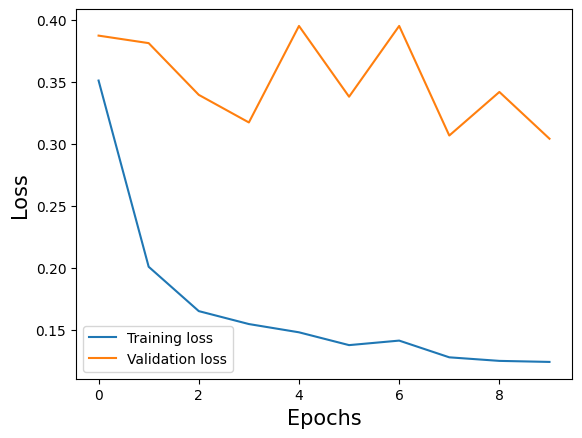

In [23]:
plot_training_loss(training_loss, validation_loss)

In [24]:
test_labels, test_preds = calculate_test_accuracy(model, test_dl)

Test accuracy: 87.98%


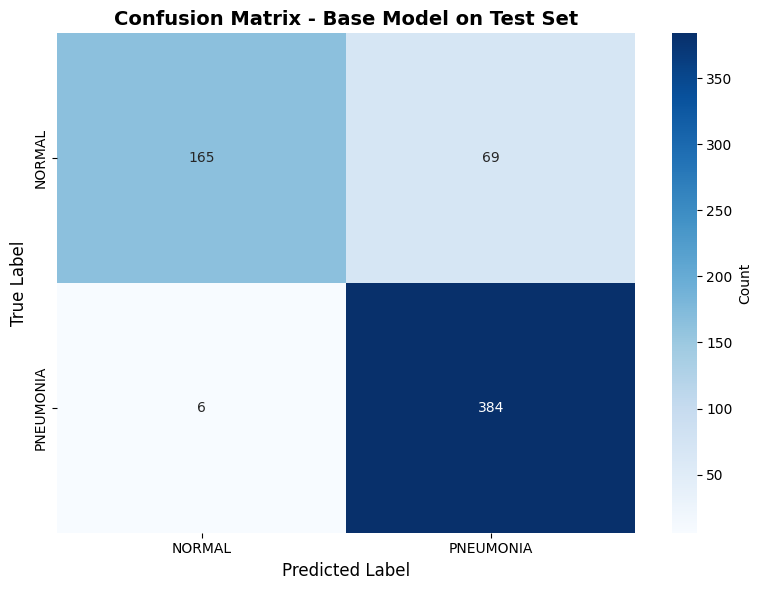


CLASSIFICATION REPORT - BASE MODEL
              precision    recall  f1-score   support

      NORMAL       0.96      0.71      0.81       234
   PNEUMONIA       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



In [25]:
cm = confusion_matrix(test_labels, test_preds)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'],
            cbar_kws={'label': 'Count'},
            ax=ax)
ax.set_ylabel('True Label', size=12)
ax.set_xlabel('Predicted Label', size=12)
ax.set_title('Confusion Matrix - Base Model on Test Set', size=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('\n' + '='*50)
print('CLASSIFICATION REPORT - BASE MODEL')
print('='*50)
print(classification_report(test_labels, test_preds, 
                          target_names=['NORMAL', 'PNEUMONIA']))

In [26]:

baseline_test_labels = test_labels
baseline_test_preds = test_preds
baseline_accuracy = accuracy_score(baseline_test_labels, baseline_test_preds)

print(f"\nBaseline Model Accuracy (threshold=0.5): {baseline_accuracy*100:.2f}%")



Baseline Model Accuracy (threshold=0.5): 87.98%


### Baseline Model Results

The baseline model achieves decent performance with simple transfer learning:
- Freezes all layers except the final classification head
- Uses standard cross-entropy loss
- Minimal fine-tuning

However, there are opportunities for improvement

## Aggressive Fine-tuning

This section will aim to improve over the base model by making some adjustment including:

- Resample the data
- Add weights to the classes
- Use a more aggressive transformation for training
- Unfreeze the last dense block AND normalization layer
- Use modest learning rates with minimal regularization (wd=1e-5)
- Train for larger number of epochs

In [27]:
train_dataset = PneumoniaDataset(root_dir='data/chest_xray/train', transform=transform)
valid_dataset = PneumoniaDataset(root_dir='data/chest_xray/val', transform=transform)

In [28]:
enhanced_train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [29]:
all_images = train_dataset.image_paths + valid_dataset.image_paths
all_labels = train_dataset.labels + valid_dataset.labels

In [30]:
indices = list(range(len(all_labels)))

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.15,
    stratify=all_labels
)

In [31]:
full_dataset = PneumoniaDataset(root_dir='data/chest_xray/train', transform=transform)

full_dataset.image_paths = all_images
full_dataset.labels = all_labels

train_dataset = Subset(full_dataset, train_idx)
valid_dataset = Subset(full_dataset, val_idx)

train_dataset.dataset.transform = enhanced_train_transform

print('Size of train dataset', len(train_dataset))
print('Size of valid dataset', len(valid_dataset))

Size of train dataset 4447
Size of valid dataset 785


In [32]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size, shuffle=True)

In [33]:
counts = Counter(train_dataset.dataset.labels)

normal_count, positive_count = counts[0], counts[1]

print('NORMAL:', normal_count)
print('PNEUMONIA:', positive_count)

NORMAL: 1349
PNEUMONIA: 3883


## Handling Class Imbalance

**Weighted Cross-Entropy Loss** assigns higher penalty to misclassifying the minority class (PNEUMONIA). This prevents the model from achieving high accuracy by simply predicting "NORMAL" for everything. The weights are inversely proportional to class frequency.


In [ ]:
total = normal_count + positive_count
weight_normal = total / (2*normal_count)
weight_positive = total / (2*positive_count)

weights = torch.tensor([weight_normal, weight_positive]).to(device)

In [35]:
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

In [36]:
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 2)
)

for param in model.classifier.parameters():
    param.requires_grad = True

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [38]:
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-4,
    weight_decay=1e-4
)

In [39]:
model, training_loss, validation_loss = train(
    model, train_dl, valid_dl, loss_fn, optimizer, scheduler=None, early_stopping=False, num_epochs=20
)

Epoch 1/20 Train loss -> 0.5043 Valid loss -> 0.3507. Valid acc -> 91.34% Epoch time: 1.07 min
Epoch 2/20 Train loss -> 0.3032 Valid loss -> 0.2507. Valid acc -> 94.27% Epoch time: 1.03 min
Epoch 3/20 Train loss -> 0.2425 Valid loss -> 0.2283. Valid acc -> 90.45% Epoch time: 1.03 min
Epoch 4/20 Train loss -> 0.2176 Valid loss -> 0.1991. Valid acc -> 94.27% Epoch time: 1.04 min
Epoch 5/20 Train loss -> 0.2005 Valid loss -> 0.1666. Valid acc -> 93.89% Epoch time: 1.02 min
Epoch 6/20 Train loss -> 0.1915 Valid loss -> 0.1800. Valid acc -> 93.76% Epoch time: 1.03 min
Epoch 7/20 Train loss -> 0.1889 Valid loss -> 0.1731. Valid acc -> 94.52% Epoch time: 1.03 min
Epoch 8/20 Train loss -> 0.1652 Valid loss -> 0.1733. Valid acc -> 93.89% Epoch time: 1.01 min
Epoch 9/20 Train loss -> 0.1629 Valid loss -> 0.1680. Valid acc -> 93.38% Epoch time: 1.04 min
Epoch 10/20 Train loss -> 0.1575 Valid loss -> 0.1592. Valid acc -> 94.14% Epoch time: 0.99 min
Epoch 11/20 Train loss -> 0.1628 Valid loss -> 0.

In [40]:
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

for param in model.features.norm5.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(
    [
        {"params": model.features.denseblock4.parameters(), "lr": 1e-5},
        {"params": model.features.norm5.parameters(), "lr": 5e-5},
        {"params": model.classifier.parameters(), "lr": 5e-4},
    ], 
    weight_decay=1e-5
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
)

In [41]:
model, training_loss, validation_loss = train(
    model, train_dl, valid_dl, loss_fn, optimizer, scheduler=scheduler, early_stopping=True, num_epochs=25
)

Epoch 1/25 Train loss -> 0.1381 Valid loss -> 0.1146. Valid acc -> 95.54% Epoch time: 1.05 min

Epoch 2/25 Train loss -> 0.1268 Valid loss -> 0.1096. Valid acc -> 96.05% Epoch time: 1.02 min

Epoch 3/25 Train loss -> 0.1165 Valid loss -> 0.0873. Valid acc -> 97.07% Epoch time: 1.02 min

Epoch 4/25 Train loss -> 0.1049 Valid loss -> 0.1033. Valid acc -> 96.56% Epoch time: 1.02 min

Epoch 5/25 Train loss -> 0.0968 Valid loss -> 0.1044. Valid acc -> 96.82% Epoch time: 1.02 min

Epoch 6/25 Train loss -> 0.0963 Valid loss -> 0.0875. Valid acc -> 96.94% Epoch time: 1.03 min

Epoch 7/25 Train loss -> 0.0889 Valid loss -> 0.0815. Valid acc -> 96.69% Epoch time: 1.03 min

Epoch 8/25 Train loss -> 0.0960 Valid loss -> 0.0800. Valid acc -> 96.82% Epoch time: 1.03 min

Epoch 9/25 Train loss -> 0.0854 Valid loss -> 0.0763. Valid acc -> 97.45% Epoch time: 1.03 min

Epoch 10/25 Train loss -> 0.0768 Valid loss -> 0.0825. Valid acc -> 97.20% Epoch time: 1.03 min

Epoch 11/25 Train loss -> 0.0809 Valid 

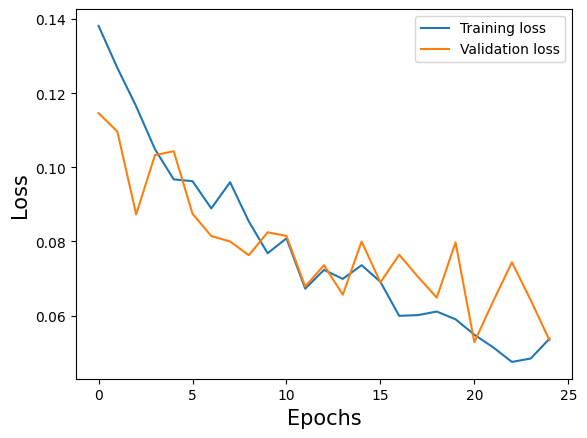

In [42]:
plot_training_loss(training_loss, validation_loss)

In [43]:
test_labels, test_preds = calculate_test_accuracy(model, test_dl, threshold=0.5)

Test accuracy: 80.61%


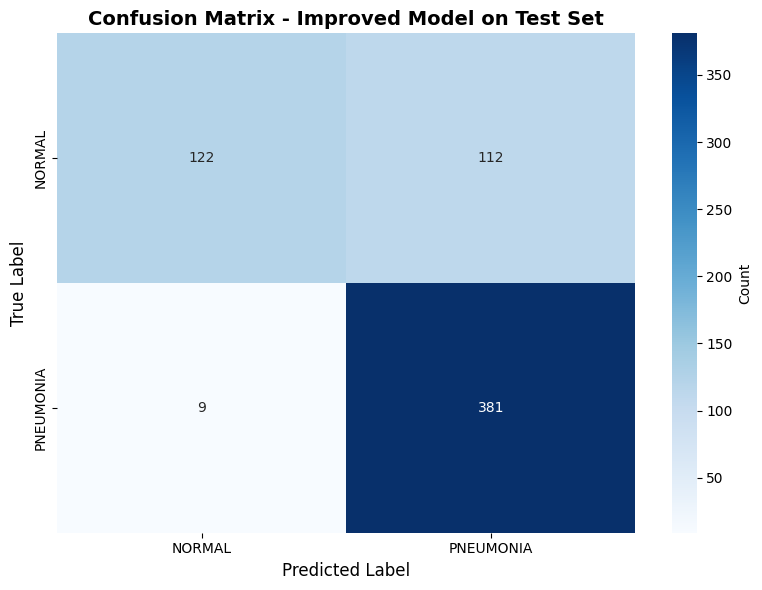


CLASSIFICATION REPORT - IMPROVED MODEL
              precision    recall  f1-score   support

      NORMAL       0.93      0.52      0.67       234
   PNEUMONIA       0.77      0.98      0.86       390

    accuracy                           0.81       624
   macro avg       0.85      0.75      0.77       624
weighted avg       0.83      0.81      0.79       624



In [44]:
cm = confusion_matrix(test_labels, test_preds)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'],
            cbar_kws={'label': 'Count'},
            ax=ax)
ax.set_ylabel('True Label', size=12)
ax.set_xlabel('Predicted Label', size=12)
ax.set_title('Confusion Matrix - Improved Model on Test Set', size=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('\n' + '='*50)
print('CLASSIFICATION REPORT - IMPROVED MODEL')
print('='*50)
print(classification_report(test_labels, test_preds, 
                          target_names=['NORMAL', 'PNEUMONIA']))

In [45]:
finetuned_accuracy = accuracy_score(test_labels, test_preds)

print("\n" + "="*50)
print("SECTION 2 RESULTS: AGGRESSIVE FINE-TUNING")
print("="*50)
print(f"Baseline Model Accuracy:  {baseline_accuracy*100:.2f}%")
print(f"Aggressive FT Accuracy:   {finetuned_accuracy*100:.2f}%")
print(f"Difference:               {(finetuned_accuracy - baseline_accuracy)*100:+.2f}%")
print("="*50)


SECTION 2 RESULTS: AGGRESSIVE FINE-TUNING
Baseline Model Accuracy:  87.98%
Aggressive FT Accuracy:   80.61%
Difference:               -7.37%

⚠️  OBSERVATION: Aggressive fine-tuning often WORSENS performance!


## Balanced Finetuning

This section will aim to use some of the techniques used in section 2 while maintaining the idea of the first section.

- Use initial train and validation set
- Use original transformations
- ONLY unfreeze denseblock with a low learning rate


In [91]:

train_dataset = PneumoniaDataset(root_dir='data/chest_xray/train', transform=train_transform)
valid_dataset = PneumoniaDataset(root_dir='data/chest_xray/val', transform=transform)

train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size, shuffle=True)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Valid Dataset Size: {len(valid_dataset)}")


Train Dataset Size: 5216
Valid Dataset Size: 16


In [231]:

model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

model.classifier = nn.Sequential(
    nn.Dropout(0.35),
    nn.Linear(model.classifier.in_features, 2)
)

for param in model.features.parameters():
    param.requires_grad = False

for param in model.features.denseblock4.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

model.to(device)

optimizer = torch.optim.AdamW(
    [
        {"params": model.features.denseblock4.parameters(), "lr": 1e-6},
        {"params": model.classifier.parameters(), "lr": 5e-4},
    ], 
    weight_decay=2e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
)


In [232]:

model, training_loss, validation_loss = train(
    model, train_dl, valid_dl, loss_fn, optimizer, 
    scheduler=scheduler, early_stopping=False, num_epochs=30
)


Epoch 1/30 Train loss -> 0.4808 Valid loss -> 0.3089. Valid acc -> 87.50% Epoch time: 1.06 min
Epoch 2/30 Train loss -> 0.2927 Valid loss -> 0.2704. Valid acc -> 81.25% Epoch time: 1.05 min
Epoch 3/30 Train loss -> 0.2437 Valid loss -> 0.2686. Valid acc -> 87.50% Epoch time: 1.05 min
Epoch 4/30 Train loss -> 0.2236 Valid loss -> 0.2362. Valid acc -> 93.75% Epoch time: 1.05 min
Epoch 5/30 Train loss -> 0.2186 Valid loss -> 0.2032. Valid acc -> 87.50% Epoch time: 1.05 min
Epoch 6/30 Train loss -> 0.1875 Valid loss -> 0.2594. Valid acc -> 93.75% Epoch time: 1.05 min
Epoch 7/30 Train loss -> 0.1855 Valid loss -> 0.2015. Valid acc -> 93.75% Epoch time: 1.05 min
Epoch 8/30 Train loss -> 0.1881 Valid loss -> 0.1987. Valid acc -> 93.75% Epoch time: 1.05 min
Epoch 9/30 Train loss -> 0.1842 Valid loss -> 0.2003. Valid acc -> 93.75% Epoch time: 1.05 min
Epoch 10/30 Train loss -> 0.1753 Valid loss -> 0.2070. Valid acc -> 93.75% Epoch time: 1.05 min
Epoch 11/30 Train loss -> 0.1699 Valid loss -> 0.

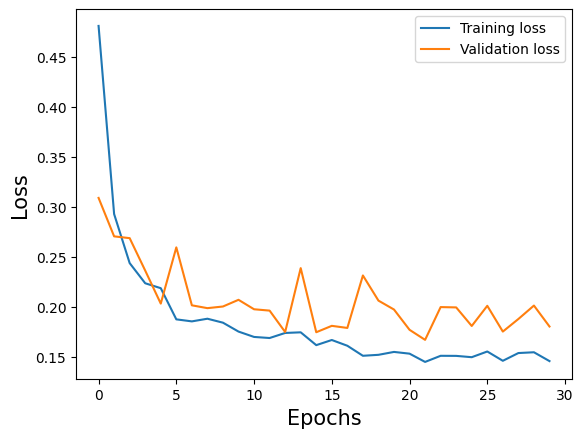

In [233]:

plot_training_loss(training_loss, validation_loss)


In [234]:

test_labels_finetuned, test_preds_finetuned = calculate_test_accuracy(model, test_dl)


Test accuracy: 90.71%


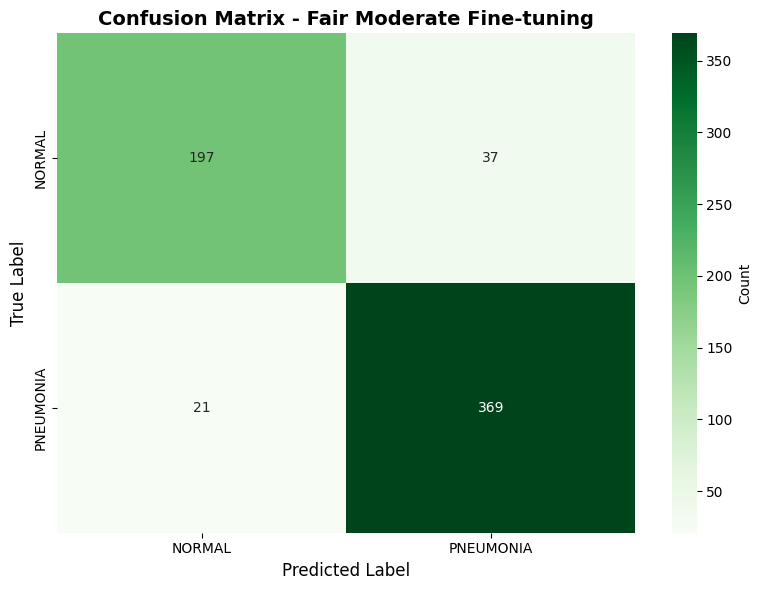


CLASSIFICATION REPORT - FAIR MODERATE
              precision    recall  f1-score   support

      NORMAL       0.90      0.84      0.87       234
   PNEUMONIA       0.91      0.95      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



In [235]:

cm = confusion_matrix(test_labels_finetuned, test_preds_finetuned)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'],
            cbar_kws={'label': 'Count'},
            ax=ax)
ax.set_ylabel('True Label', size=12)
ax.set_xlabel('Predicted Label', size=12)
ax.set_title('Confusion Matrix - Fair Moderate Fine-tuning', size=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('\n' + '='*50)
print('CLASSIFICATION REPORT - FAIR MODERATE')
print('='*50)
print(classification_report(test_labels_finetuned, test_preds_finetuned, 
                          target_names=['NORMAL', 'PNEUMONIA']))


In [ ]:

finetuned_moderate_accuracy = accuracy_score(test_labels_finetuned, test_preds_finetuned)

print("\n" + "="*80)
print("FINAL COMPARISON: ALL APPROACHES")
print("="*80)
print(f"SECTION 1 - Minimum FT:                         {baseline_accuracy*100:.2f}%")
print(f"SECTION 2 - Aggressive FT + Resampled:          {finetuned_accuracy*100:.2f}%  (Δ {(finetuned_accuracy - baseline_accuracy)*100:+.2f}%)")
print(f"SECTION 3 - Moderate FT:                        {finetuned_moderate_accuracy*100:.2f}%  (Δ {(finetuned_moderate_accuracy - baseline_accuracy)*100:+.2f}%)")
print("="*80)

print("="*80)



FINAL COMPARISON: ALL APPROACHES (WITH FAIR DATA)
SECTION 1 - Minimum FT:                         87.98%
SECTION 2 - Aggressive FT + Resampled:          80.61%  (Δ -7.37%)
SECTION 3 - Moderate FT:                        90.71%  (Δ +2.72%)


## Conclusion

The balanced fine-tuning approach (Section 3) achieved better generalization compared to the baseline model. While recall worsen (more missed diagnoses), the accuracy increased. For medical applications, recall is particularly critical—minimizing false negatives (missed pneumonia cases) could be achieve by finding the best treshold for classifying a case as positive using the ROC curve analysis.

**Future improvements** ensemble methods, or exploring other architectures like ResNet or Vision Transformers could improve the current model. Additionally, other hyperparameters could improve the current architecture. Upon using different epochs, learning rates, training schedule, transformations, etc., the last section had gains over the best model, so a different combination of hyperparamters could generalize even better.
